# Detecting Pneumonia 

In [35]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
# Common
import os 
import keras
import numpy as np 
import tensorflow as tf
import pandas as pd
import seaborn as sbn
sbn.set()


# Data 
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2

In [39]:
x  = "H:/chestds/chest_xray/train/"
class_names = os.listdir(x)
classes = len(path)
class_names


['NORMAL', 'PNEUMONIA']

In [42]:
# Class Names
import os
root_path = "H:/chestds/chest_xray/train/"
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]


# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 2 
Class Names : ['NORMAL', 'PNEUMONIA']


In [43]:
# Visualize 
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution", hole=0.1)
fig.update_layout({'title':{'x':0.6}})
fig.show()

In [45]:
# Initialize Generator
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10)
valid_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255.)

# Load Data
train_ds = train_gen.flow_from_directory(root_path, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)
valid_ds = valid_gen.flow_from_directory(root_path.replace('train','val'), class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)
test_ds = test_gen.flow_from_directory(root_path.replace('train', 'test'), class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [47]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(32)
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
        
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

show_images()

In [48]:
# Pre-Trained Model 
from tensorflow.keras.applications import ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2
base_model = ResNet50V2(input_shape=(256,256,3), include_top=False)
base_model.trainable = False

# Model Architecture
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

name = "ResNet50V2"
model = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(n_classes, activation='softmax')
], name=name)

# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

cbs = [EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint(name + ".h5", save_best_only=True)]

# Model Compiling
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Training
history = model.fit(train_ds, validation_data=valid_ds, callbacks=cbs, epochs=50,verbose=1)

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9352

C:\Users\Bamwesigye Calvin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



163/163 [==============================] - 577s 4s/step - loss: 0.1571 - accuracy: 0.9352 - val_loss: 0.1248 - val_accuracy: 0.9375
Epoch 2/50
163/163 [==============================] - 530s 3s/step - loss: 0.0759 - accuracy: 0.9720 - val_loss: 0.3828 - val_accuracy: 0.8750
Epoch 3/50
163/163 [==============================] - 538s 3s/step - loss: 0.0648 - accuracy: 0.9753 - val_loss: 0.1433 - val_accuracy: 0.8750
Epoch 4/50
163/163 [==============================] - 534s 3s/step - loss: 0.0645 - accuracy: 0.9751 - val_loss: 0.6983 - val_accuracy: 0.7500


In [49]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title('Accuracy')
plt.show()

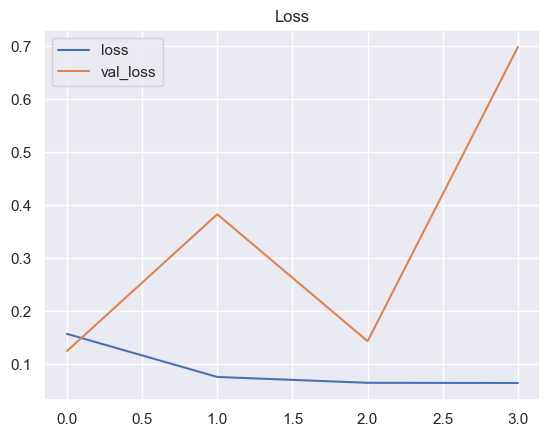

In [50]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

In [51]:
# Specify Model Path
model_path = "C:/Users/Bamwesigye Calvin/Desktop/ResNet50V2.h5"
model = load_model(model_path)

# Architecture
model.summary()

Model: "ResNet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24089858 (91.90 MB)
Trainable params: 525058 (2.00 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [52]:
# Evaluation on test Set
from keras.models import Sequential, load_model
model.evaluate(test_ds)

20/20 [==============================] - 51s 2s/step - loss: 0.4238 - accuracy: 0.8381


[0.42384400963783264, 0.8381410241127014]

1/1 [==============================] - 0s 120ms/step


IndexError: index 16 is out of bounds for axis 0 with size 16

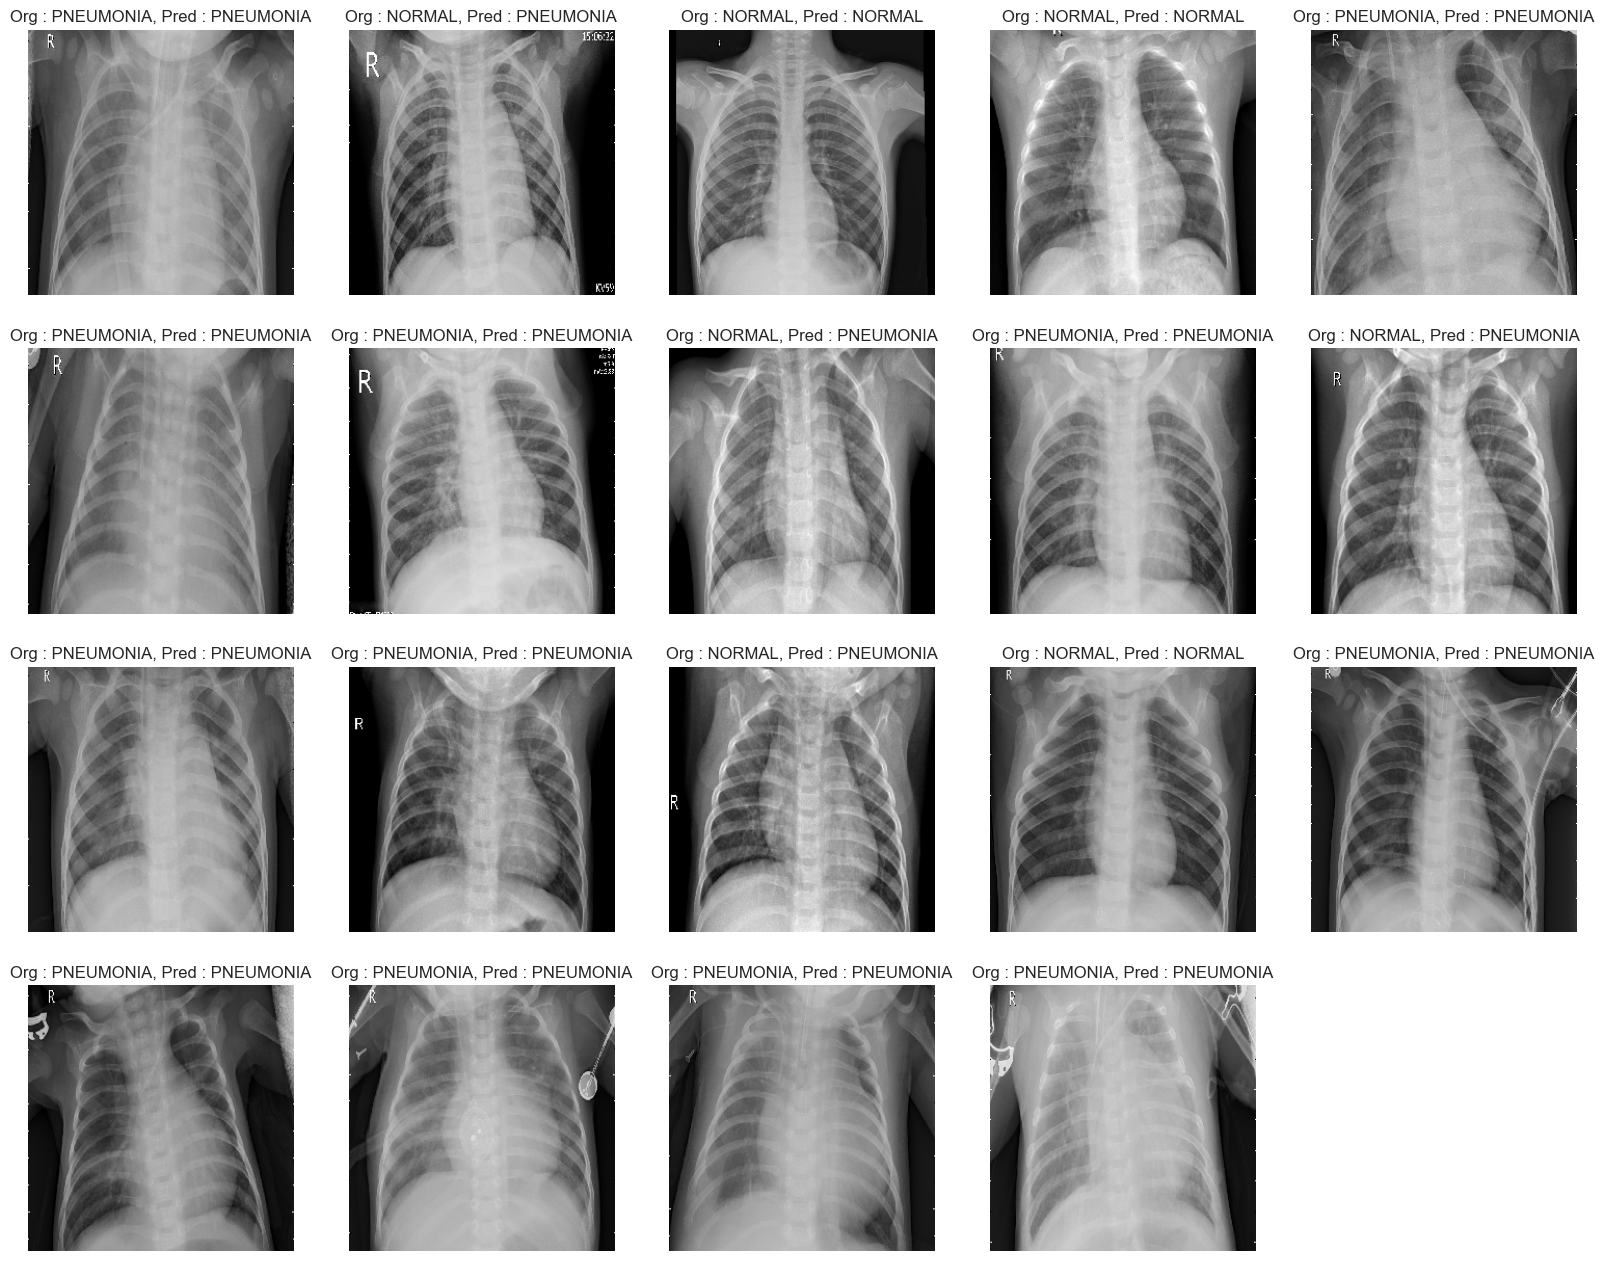

In [54]:
# Visualize Predictions
show_images(model=model, data=test_ds)